<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week4/RNN_GRU_LSTM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.13.1 torchtext==0.14.1



  Using cached torch-1.13.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
ERROR: Could not find a version that satisfies the requirement torchtext==0.14.1 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0)
ERROR: No matching distribution found for torchtext==0.14.1


In [2]:
!pip install datasets


# **RNN**

In [3]:
# Mengimpor library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

In [4]:
# Set seed for reproducibility
torch.manual_seed(42)

In [5]:
# Mengunduh dataset IMDB dari Hugging Face
def load_imdb_data():
    dataset = load_dataset('imdb')
    return dataset['train'], dataset['test']

train_data, test_data = load_imdb_data()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Membuat custom Dataset untuk IMDB
class IMDBDataset(Dataset):
    def __init__(self, data, max_len=500):
        self.data = data
        self.texts = [item['text'] for item in data]
        self.labels = [item['label'] for item in data]
        self.max_len = max_len

        # Membuat representasi tokenisasi (menggunakan pre-trained GloVe atau model lainnya)
        self.vocab = set()
        for text in self.texts:
            self.vocab.update(text.split())
        self.vocab = {word: i for i, word in enumerate(self.vocab)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Men-tokenisasi kata
        tokens = [self.vocab.get(word, 0) for word in text.split()]

        # Padding sequence jika panjangnya lebih pendek dari max_len
        tokens = tokens[:self.max_len]  # Truncate to max_len if it's too long
        tokens = tokens + [0] * (self.max_len - len(tokens))  # Pad with zeros

        return torch.tensor(tokens), torch.tensor(label)


In [7]:
# Membuat DataLoader untuk training dan testing
train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [8]:
# Membuat model RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded)
        out = self.fc(rnn_out[:, -1, :])  # Hanya mengambil output terakhir
        return self.sigmoid(out)

In [9]:
# Menyiapkan parameter model
VOCAB_SIZE = len(train_dataset.vocab)
EMBED_SIZE = 100
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1  # Binary classification
model = RNNModel(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(torch.device('cuda'))


In [10]:
# Menyiapkan optimizer dan loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [11]:
# Fungsi untuk menghitung dan menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [12]:
# Fungsi untuk melatih model
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in train_loader:
        texts, labels = batch
        texts = texts.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))
        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = accuracy_score(labels.cpu(), predictions.detach().cpu().round())  # Detach predictions
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)


In [13]:
# Fungsi untuk mengevaluasi model dan menampilkan confusion matrix
def evaluate_model_with_confusion_matrix(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            texts, labels = batch
            texts = texts.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))

            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels.float())
            acc = accuracy_score(labels.cpu(), predictions.detach().cpu().round())  # Detach predictions

            epoch_loss += loss.item()
            epoch_acc += acc
            all_preds.extend(predictions.detach().cpu().round().numpy())  # Detach predictions
            all_labels.extend(labels.cpu().numpy())

    # Menampilkan confusion matrix
    plot_confusion_matrix(all_labels, all_preds)

    return epoch_loss / len(test_loader), epoch_acc / len(test_loader), all_preds, all_labels

In [14]:
# Fungsi untuk plot grafik loss dan akurasi
def plot_training_progress(train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Loss Over Time")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title("Accuracy Over Time")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [15]:
NUM_EPOCHS = 15
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

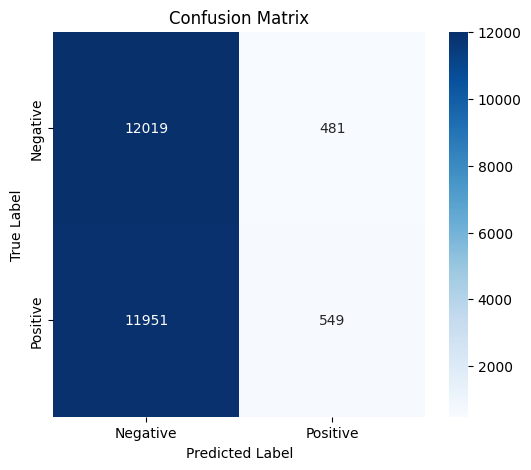

Epoch 1:
Train Loss: 0.696, Train Acc: 0.493
Test Loss: 0.694, Test Acc: 0.502
Precision: 0.533, Recall: 0.044, F1: 0.081
AUC: 0.503


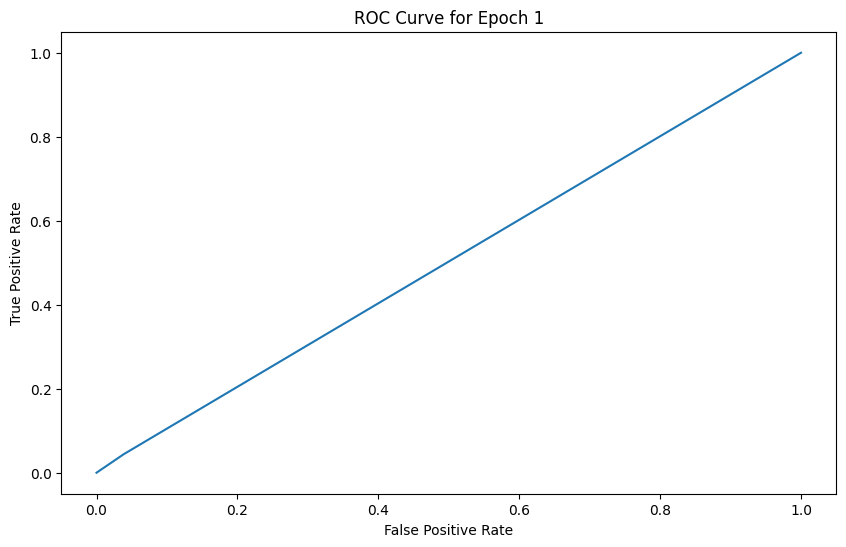

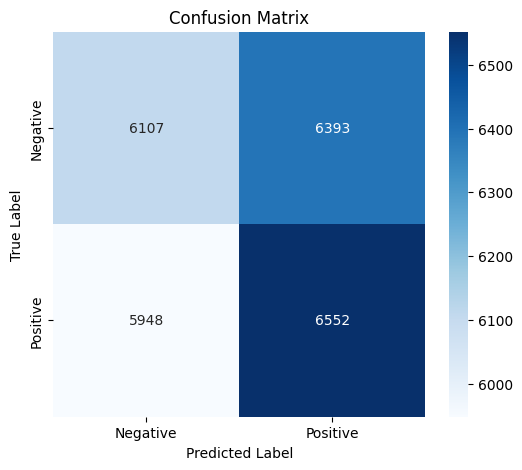

Epoch 2:
Train Loss: 0.696, Train Acc: 0.502
Test Loss: 0.695, Test Acc: 0.506
Precision: 0.506, Recall: 0.524, F1: 0.515
AUC: 0.506


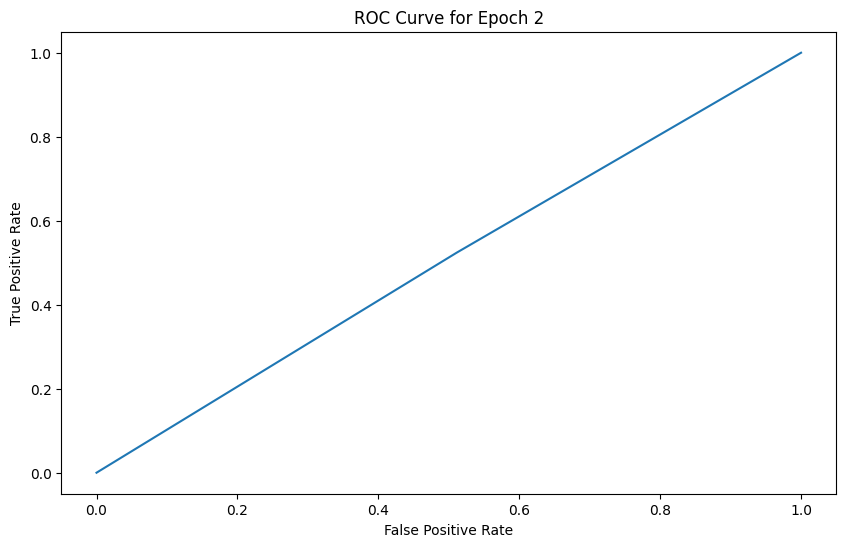

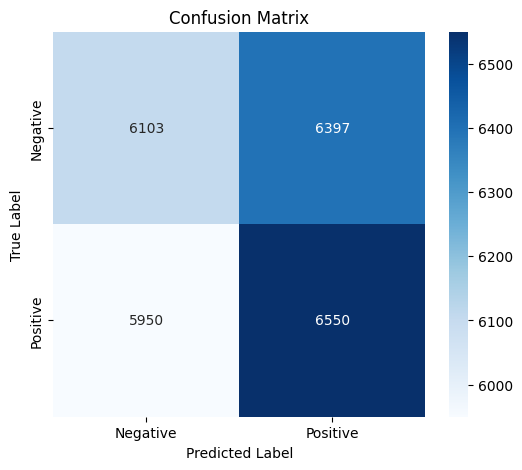

Epoch 3:
Train Loss: 0.694, Train Acc: 0.507
Test Loss: 0.693, Test Acc: 0.506
Precision: 0.506, Recall: 0.524, F1: 0.515
AUC: 0.506


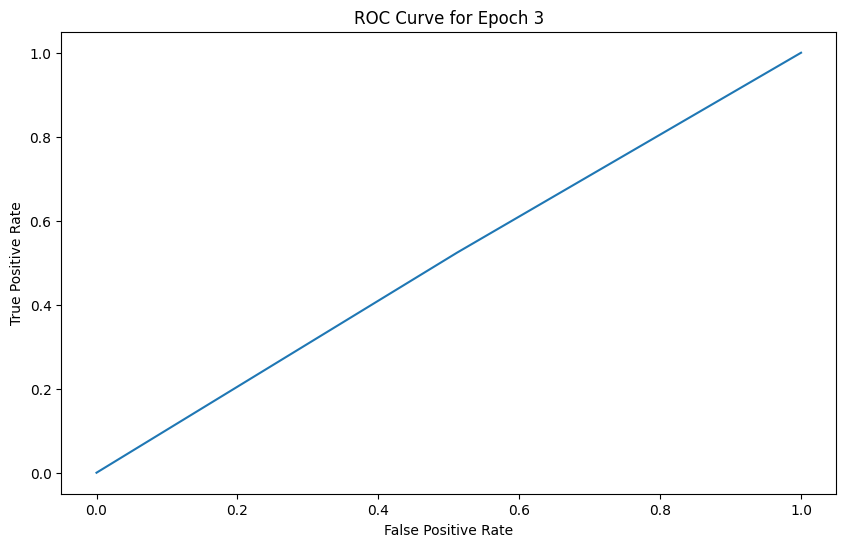

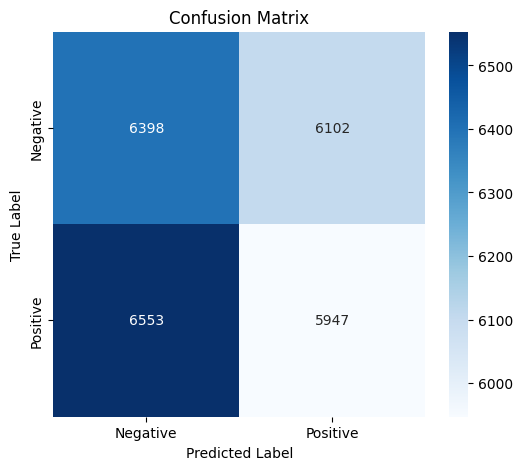

Epoch 4:
Train Loss: 0.694, Train Acc: 0.505
Test Loss: 0.694, Test Acc: 0.494
Precision: 0.494, Recall: 0.476, F1: 0.485
AUC: 0.494


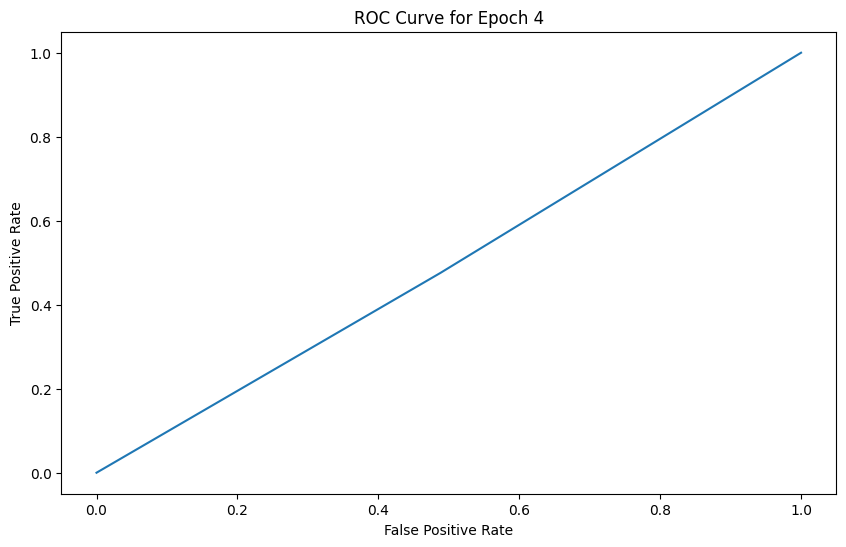

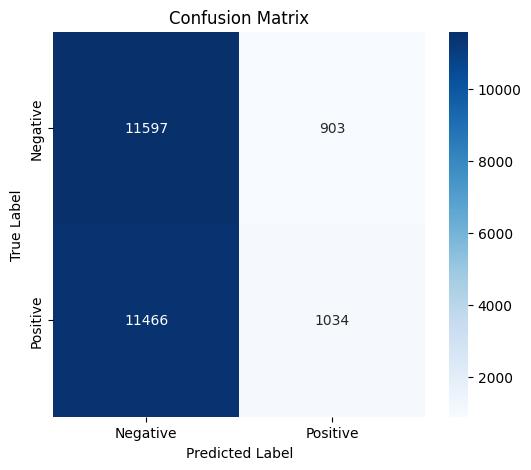

Epoch 5:
Train Loss: 0.694, Train Acc: 0.502
Test Loss: 0.693, Test Acc: 0.505
Precision: 0.534, Recall: 0.083, F1: 0.143
AUC: 0.505


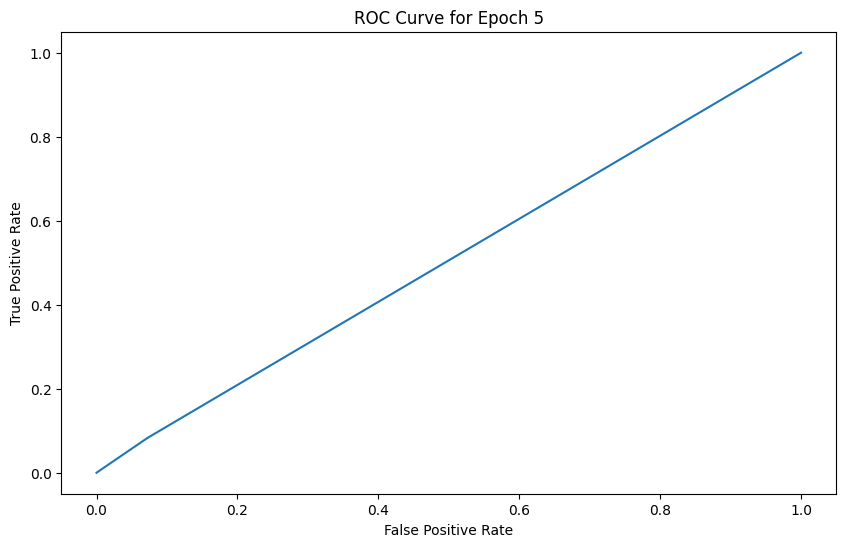

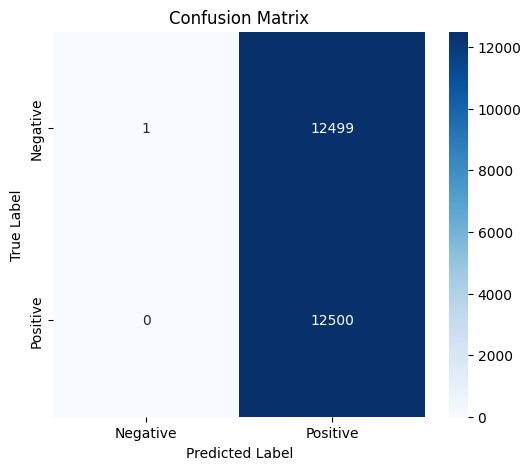

Epoch 6:
Train Loss: 0.694, Train Acc: 0.503
Test Loss: 0.693, Test Acc: 0.501
Precision: 0.500, Recall: 1.000, F1: 0.667
AUC: 0.500


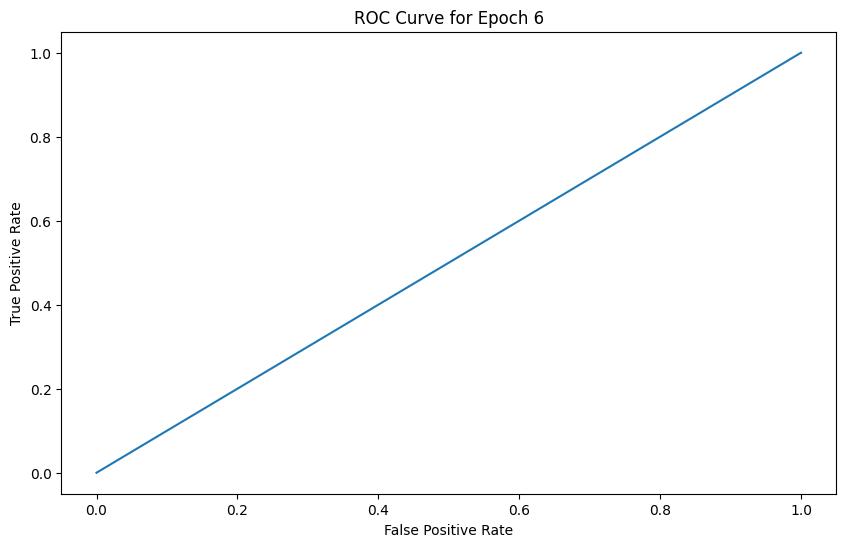

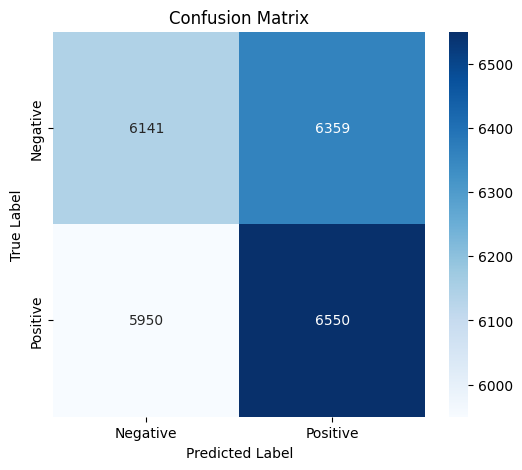

Epoch 7:
Train Loss: 0.695, Train Acc: 0.509
Test Loss: 0.697, Test Acc: 0.508
Precision: 0.507, Recall: 0.524, F1: 0.516
AUC: 0.508


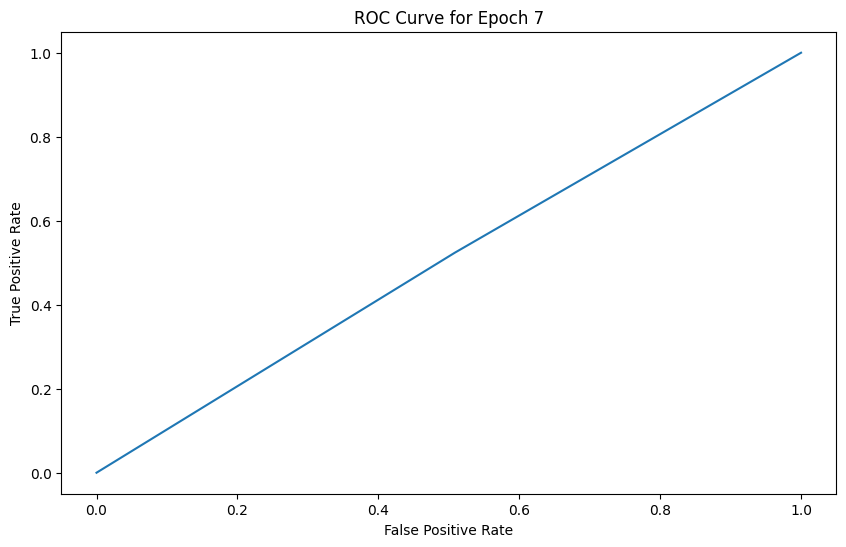

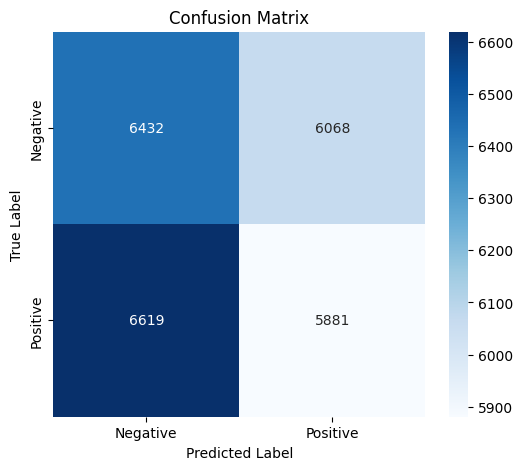

Epoch 8:
Train Loss: 0.695, Train Acc: 0.501
Test Loss: 0.705, Test Acc: 0.492
Precision: 0.492, Recall: 0.470, F1: 0.481
AUC: 0.493


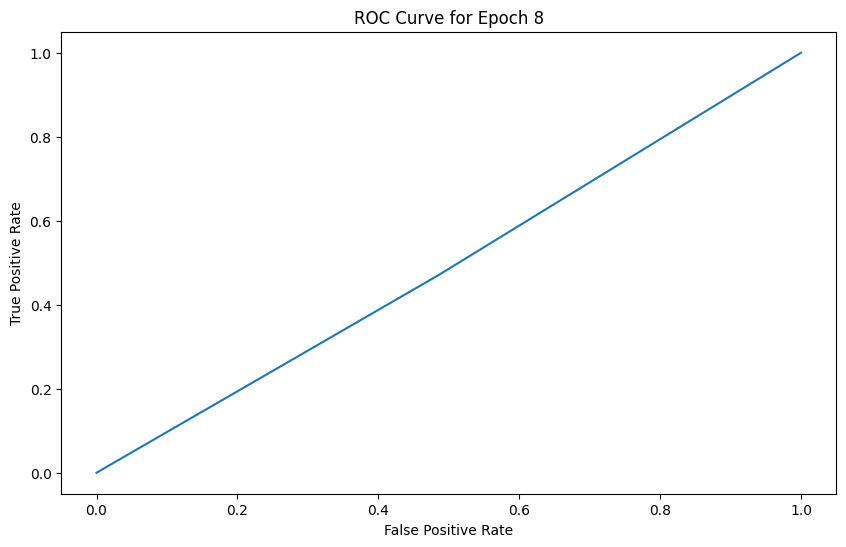

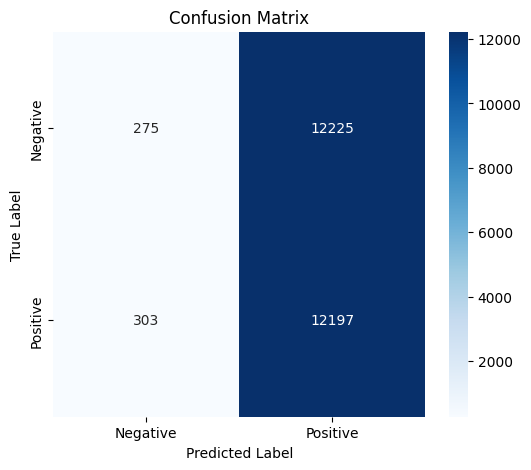

Epoch 9:
Train Loss: 0.693, Train Acc: 0.507
Test Loss: 0.695, Test Acc: 0.499
Precision: 0.499, Recall: 0.976, F1: 0.661
AUC: 0.499


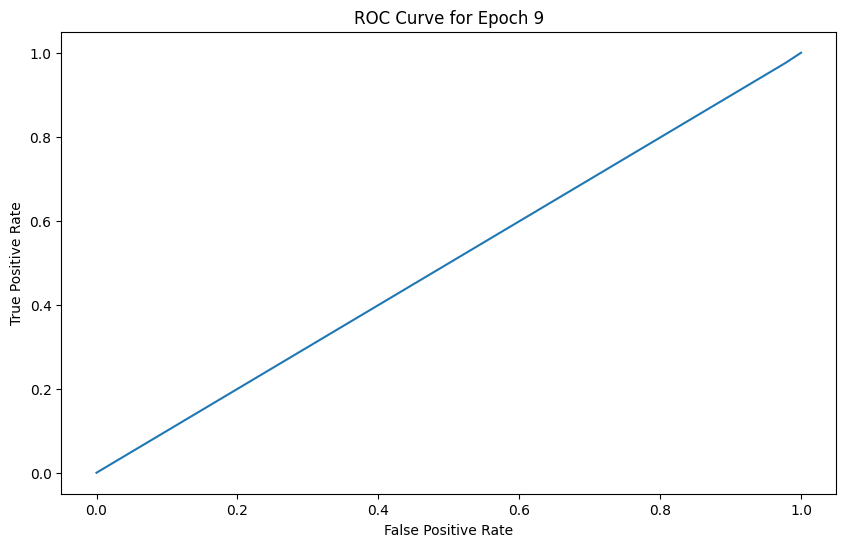

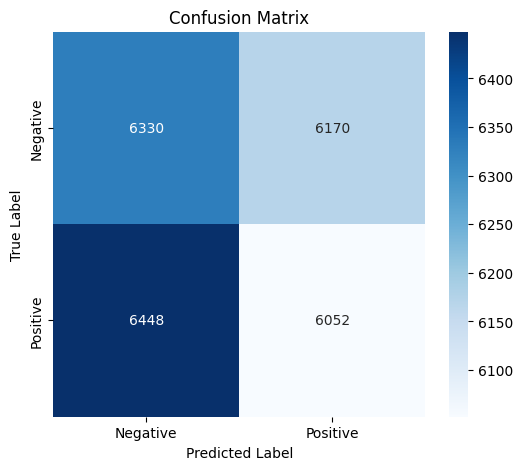

Epoch 10:
Train Loss: 0.694, Train Acc: 0.505
Test Loss: 0.695, Test Acc: 0.495
Precision: 0.495, Recall: 0.484, F1: 0.490
AUC: 0.495


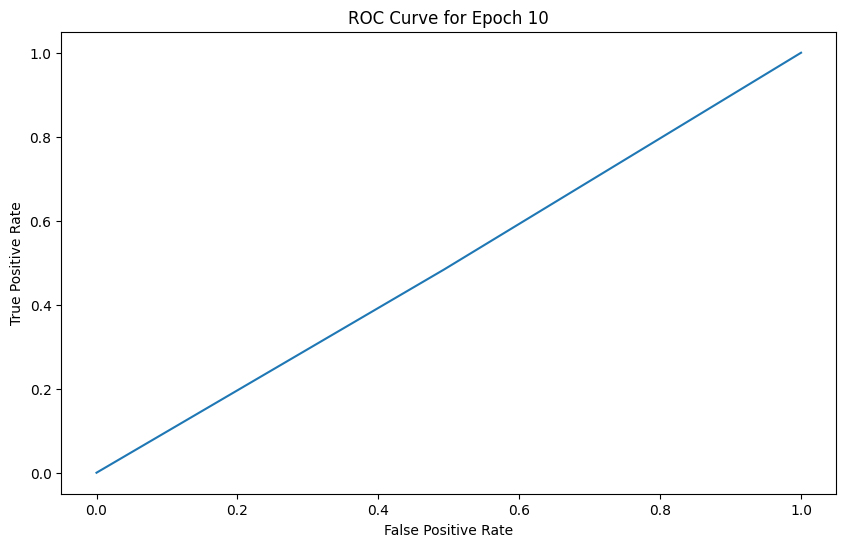

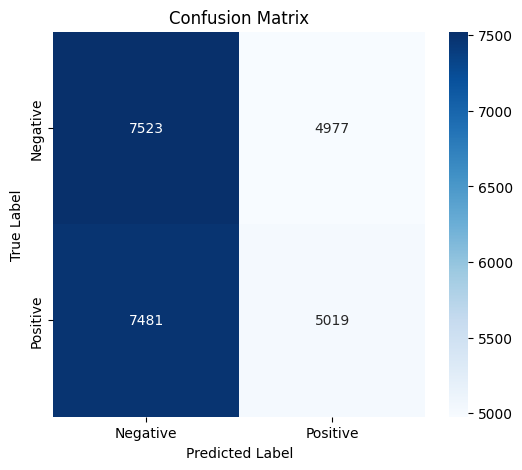

Epoch 11:
Train Loss: 0.694, Train Acc: 0.501
Test Loss: 0.694, Test Acc: 0.502
Precision: 0.502, Recall: 0.402, F1: 0.446
AUC: 0.502


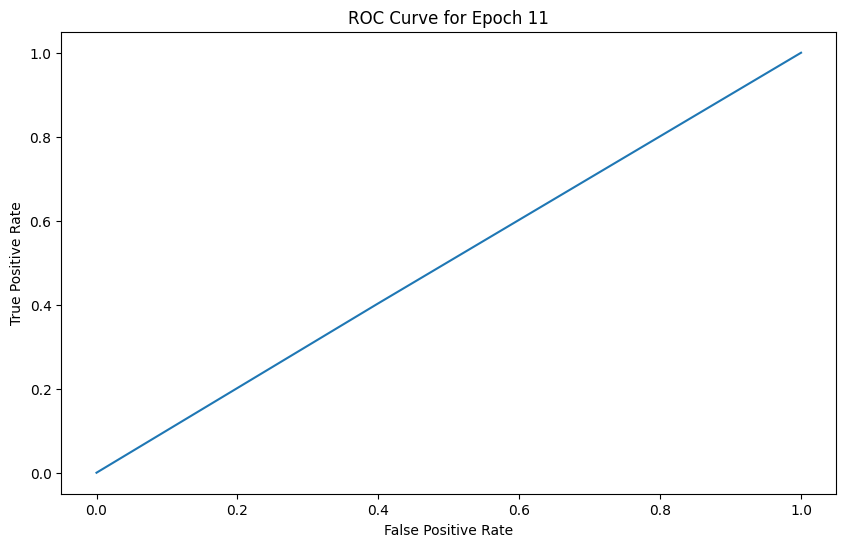

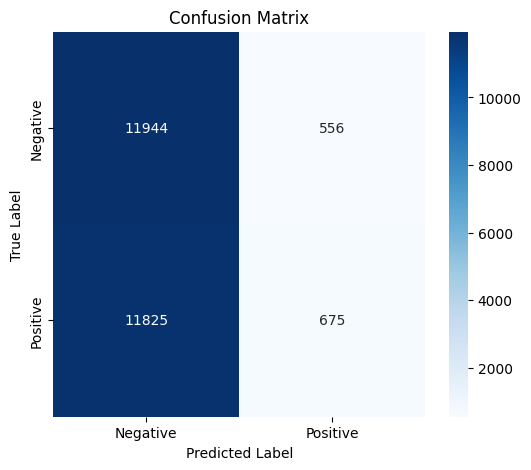

Epoch 12:
Train Loss: 0.692, Train Acc: 0.514
Test Loss: 0.696, Test Acc: 0.504
Precision: 0.548, Recall: 0.054, F1: 0.098
AUC: 0.505


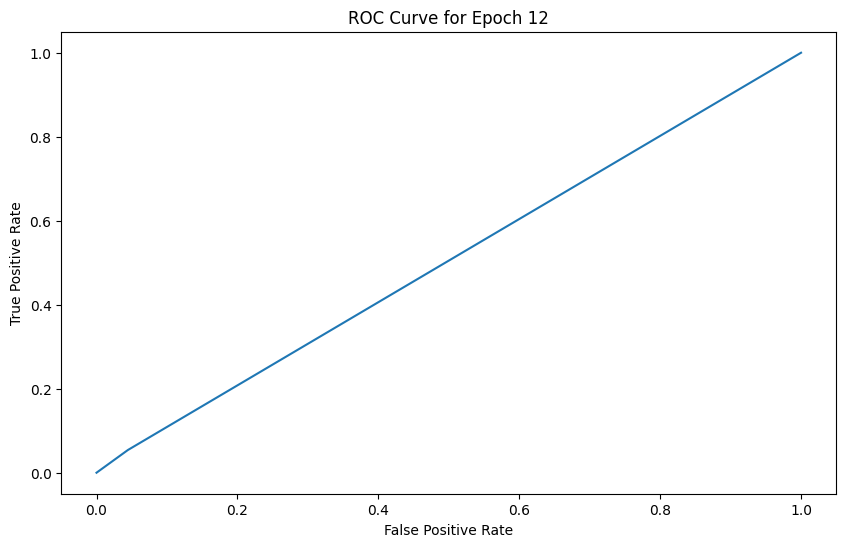

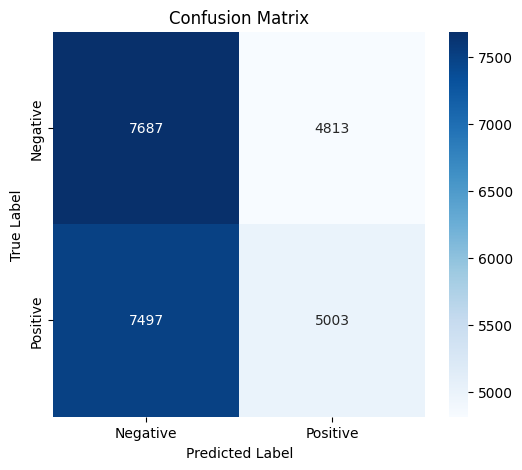

Epoch 13:
Train Loss: 0.684, Train Acc: 0.520
Test Loss: 0.701, Test Acc: 0.507
Precision: 0.510, Recall: 0.400, F1: 0.448
AUC: 0.508


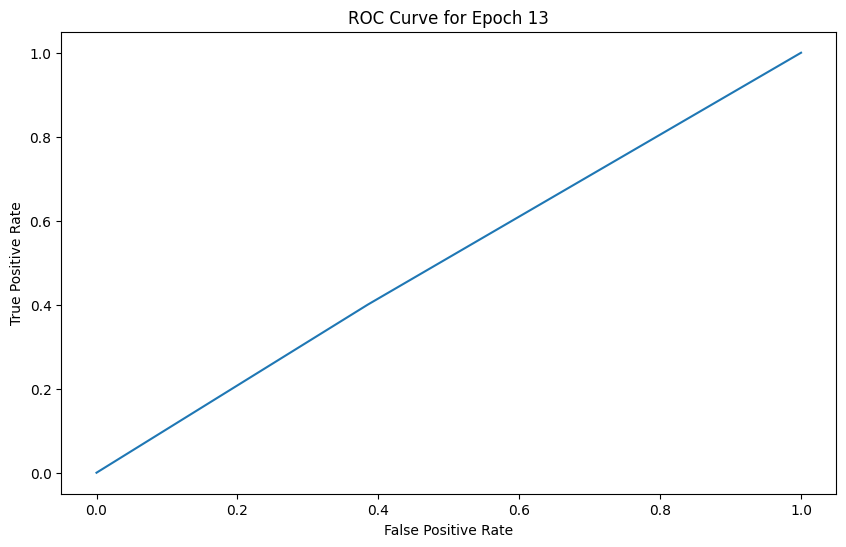

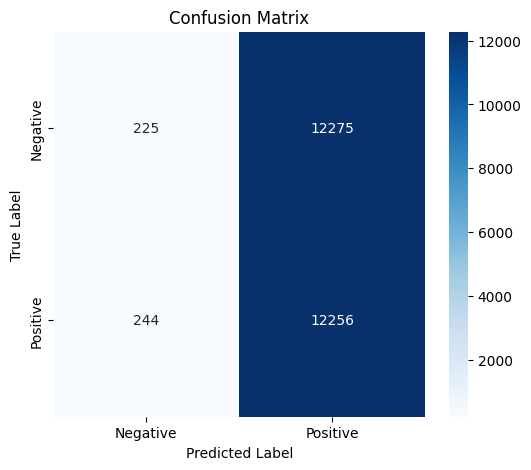

Epoch 14:
Train Loss: 0.680, Train Acc: 0.519
Test Loss: 0.698, Test Acc: 0.500
Precision: 0.500, Recall: 0.980, F1: 0.662
AUC: 0.499


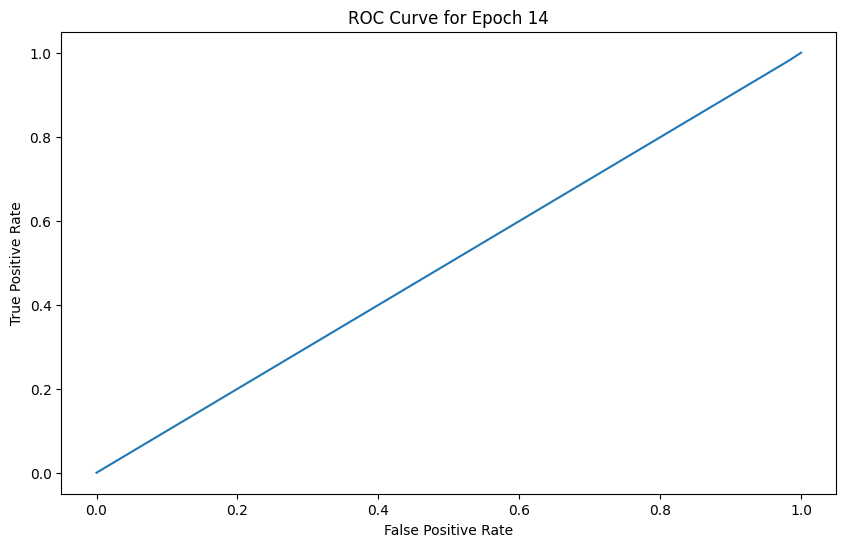

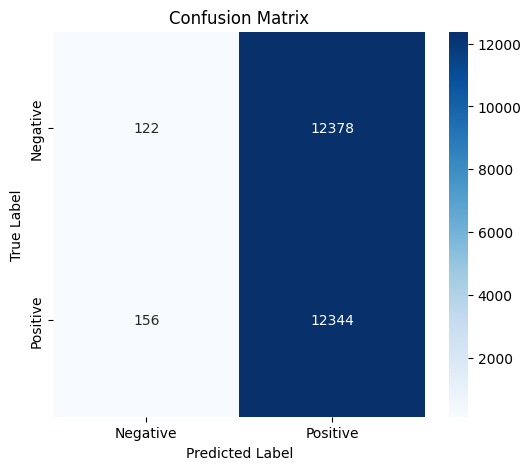

Epoch 15:
Train Loss: 0.692, Train Acc: 0.507
Test Loss: 0.696, Test Acc: 0.499
Precision: 0.499, Recall: 0.988, F1: 0.663
AUC: 0.499


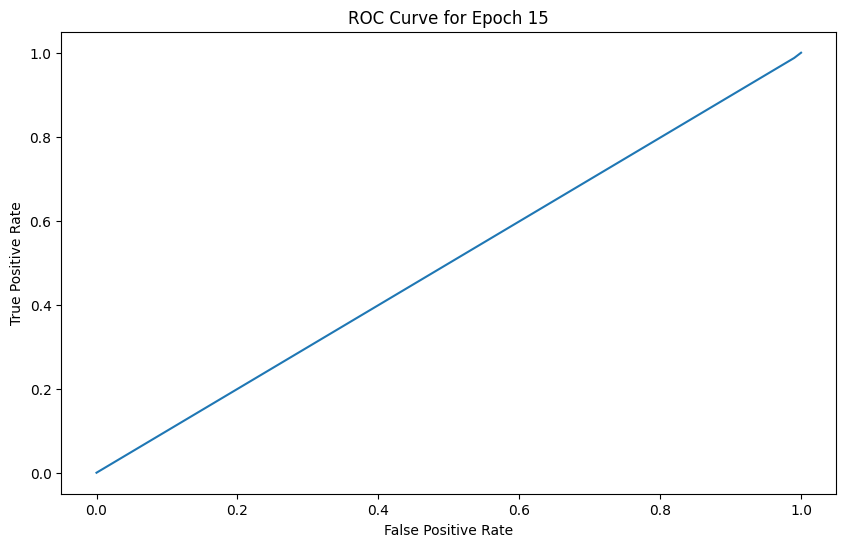

In [16]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_preds, test_labels = evaluate_model_with_confusion_matrix(model, test_loader, criterion)

    # Menyimpan hasil
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Mencetak metrik per epoch
    print(f'Epoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}')
    print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')

    # Menghitung metrik lainnya
    precision = precision_score(test_labels, test_preds)
    recall = recall_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds)
    auc = roc_auc_score(test_labels, test_preds)
    fpr, tpr, _ = roc_curve(test_labels, test_preds)

    print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')
    print(f'AUC: {auc:.3f}')

    # Visualize ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.title(f'ROC Curve for Epoch {epoch+1}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

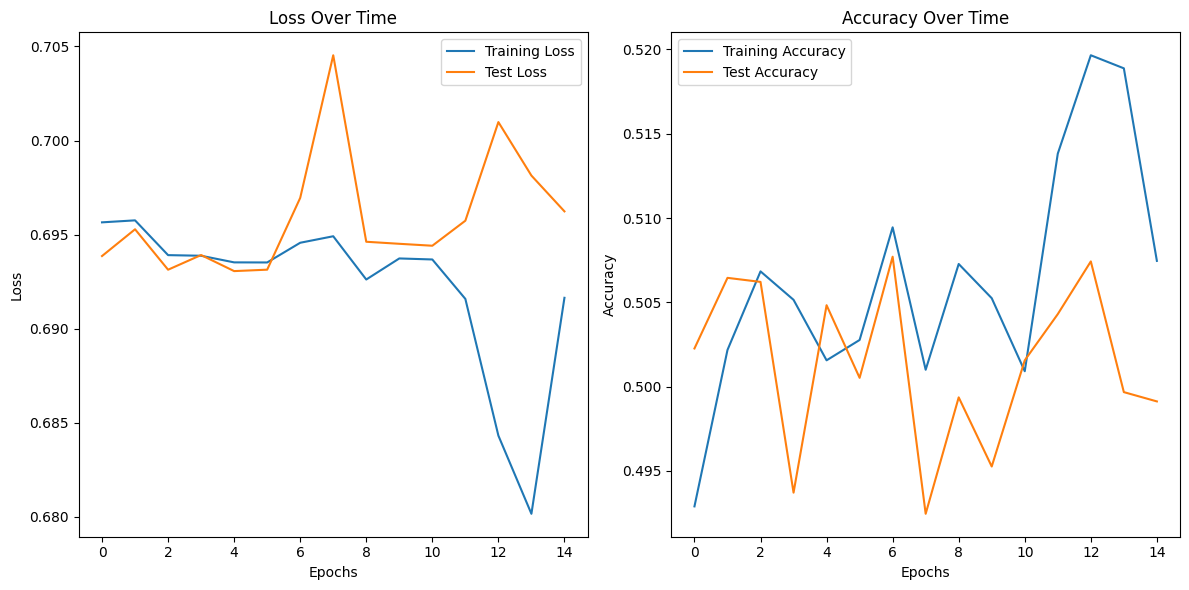

In [17]:
# Plot training progress
plot_training_progress(train_losses, test_losses, train_accuracies, test_accuracies)

# **GRU**

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
from keras.preprocessing.sequence import pad_sequences


In [50]:
# Menyiapkan dataset IMDb dengan jumlah kata yang dibatasi
num_words = 30000  # Atau 50000 sesuai permintaan
maxlen = 300  # Atau 500 sesuai permintaan

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [51]:
# Menyusun ulang urutan data untuk konsistensi panjang
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [52]:
class GRUNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers):
        super(GRUNetwork, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Ambil output dari langkah terakhir
        out = self.fc(gru_out)
        return out

In [65]:
# Parameter model
input_dim = num_words
embedding_dim = 128
hidden_dim = 128
output_dim = 1  # Binary classification
n_layers = 2

In [66]:
model = GRUNetwork(input_dim, embedding_dim, hidden_dim, output_dim, n_layers)


In [67]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


GRUNetwork(
  (embedding): Embedding(30000, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [71]:
epochs = 10
batch_size = 32

train_data = torch.tensor(x_train)
train_labels = torch.tensor(y_train).float()

test_data = torch.tensor(x_test)
test_labels = torch.tensor(y_test).float()

In [72]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for i in range(0, len(train_data), batch_size):
        # Mengambil batch data
        x_batch = train_data[i:i+batch_size].to(device)
        y_batch = train_labels[i:i+batch_size].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_data)}')

Epoch 1/10, Loss: 0.0010099023700575343
Epoch 2/10, Loss: 0.0005852449489792343
Epoch 3/10, Loss: 0.00045930026746413206
Epoch 4/10, Loss: 0.0003639602491514233
Epoch 5/10, Loss: 0.00044287464193243066
Epoch 6/10, Loss: 0.000289238514323406
Epoch 7/10, Loss: 0.00020805376528449415
Epoch 8/10, Loss: 7.97586836287337e-05
Epoch 9/10, Loss: 0.00023259149819295999
Epoch 10/10, Loss: 0.0002239206351940629


Accuracy: 0.87188
Precision: 0.8988416988416988
Recall: 0.83808
F1 Score: 0.867398054233078
AUC: 0.9456121023999999


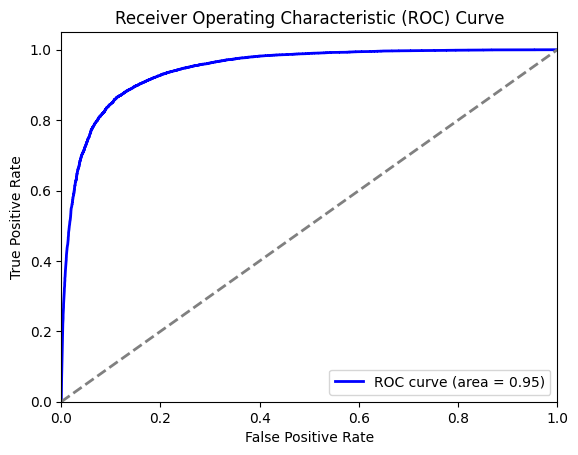

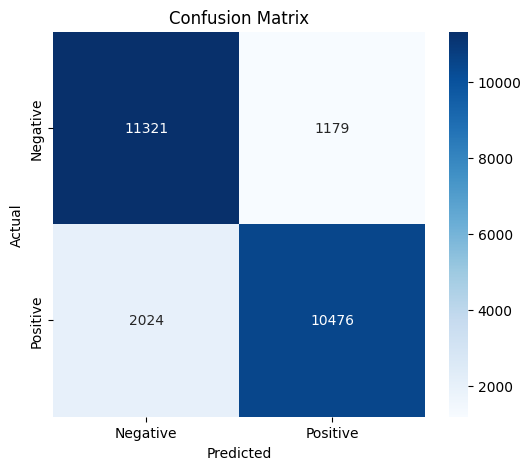

True Negative: 11321, False Positive: 1179, False Negative: 2024, True Positive: 10476


In [79]:
# Evaluasi Model dalam Batch
model.eval()
y_preds = []
y_true = []

# Tentukan ukuran batch yang lebih kecil
batch_size = 32

with torch.no_grad():  # Pastikan tidak menyimpan gradient selama evaluasi
    for i in range(0, len(test_data), batch_size):
        # Ambil batch data
        x_batch = test_data[i:i + batch_size].to(device)
        y_batch = test_labels[i:i + batch_size].to(device)

        # Prediksi menggunakan model
        y_pred = model(x_batch)

        # Terapkan sigmoid untuk mengubah output menjadi probabilitas
        y_pred = torch.sigmoid(y_pred).cpu().numpy()

        # Simpan hasil prediksi dan label yang benar
        y_preds.append(y_pred)
        y_true.append(y_batch.cpu().numpy())

# Gabungkan prediksi dan label
y_preds = np.concatenate(y_preds, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Menghitung nilai prediksi
y_pred_label = (y_preds > 0.5).astype(int)

# Evaluasi metrics
accuracy = accuracy_score(y_true, y_pred_label)
precision = precision_score(y_true, y_pred_label)
recall = recall_score(y_true, y_pred_label)
f1 = f1_score(y_true, y_pred_label)
auc = roc_auc_score(y_true, y_preds)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

# Visualisasi ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_preds)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Visualisasi Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_label)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Menampilkan nilai-nilai dari confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Negative: {tn}, False Positive: {fp}, False Negative: {fn}, True Positive: {tp}")


# **LSTM**

In [80]:
# Install dan import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [81]:
# Setting device untuk GPU atau TPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
# Download dataset IMDb
num_words = 30000  # Bisa menggunakan antara 30.000 - 50.000 kata paling sering
maxlen = 300  # Mengatur panjang maksimum kalimat
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)


In [83]:
# Padding untuk panjang kalimat agar sama panjang
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [84]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Mengambil output dari timestep terakhir
        out = self.fc(out)
        return out

In [85]:
# Set parameter
input_size = 1  # Data input memiliki satu dimensi per kata
hidden_size = 128
output_size = 2  # Klasifikasi biner (positif / negatif)
num_layers = 3

In [87]:
# Model dan optimisasi
model = LSTM_Model(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [91]:
# Menambahkan dimensi untuk fitur per kata
x_train = np.expand_dims(x_train, axis=-1)  # Bentuk baru: (batch_size, seq_len, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Bentuk baru: (batch_size, seq_len, 1)

# Mengubah menjadi tensor PyTorch
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)


In [92]:
# DataLoader untuk training dan testing
train_data = torch.utils.data.TensorDataset(x_train, torch.tensor(y_train, dtype=torch.long))
test_data = torch.utils.data.TensorDataset(x_test, torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [97]:
# Training loop
num_epochs = 20
train_loss_list = []
test_acc_list = []

In [98]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Hitung akurasi
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss_list.append(running_loss / len(train_loader))
    test_acc_list.append(correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

Epoch [1/20], Loss: 0.6616, Accuracy: 0.6006
Epoch [2/20], Loss: 0.6571, Accuracy: 0.6066
Epoch [3/20], Loss: 0.6512, Accuracy: 0.6138
Epoch [4/20], Loss: 0.6465, Accuracy: 0.6198
Epoch [5/20], Loss: 0.6396, Accuracy: 0.6252
Epoch [6/20], Loss: 0.6304, Accuracy: 0.6386
Epoch [7/20], Loss: 0.6239, Accuracy: 0.6463
Epoch [8/20], Loss: 0.6140, Accuracy: 0.6552
Epoch [9/20], Loss: 0.6059, Accuracy: 0.6652
Epoch [10/20], Loss: 0.5939, Accuracy: 0.6738
Epoch [11/20], Loss: 0.5831, Accuracy: 0.6813
Epoch [12/20], Loss: 0.5673, Accuracy: 0.6972
Epoch [13/20], Loss: 0.5509, Accuracy: 0.7093
Epoch [14/20], Loss: 0.5316, Accuracy: 0.7206
Epoch [15/20], Loss: 0.5108, Accuracy: 0.7363
Epoch [16/20], Loss: 0.4903, Accuracy: 0.7508
Epoch [17/20], Loss: 0.4644, Accuracy: 0.7660
Epoch [18/20], Loss: 0.4336, Accuracy: 0.7877
Epoch [19/20], Loss: 0.4090, Accuracy: 0.8020
Epoch [20/20], Loss: 0.3808, Accuracy: 0.8164


Accuracy: 0.6031
Precision: 0.5970
Recall: 0.6346
F1 Score: 0.6152
AUC: 0.6031


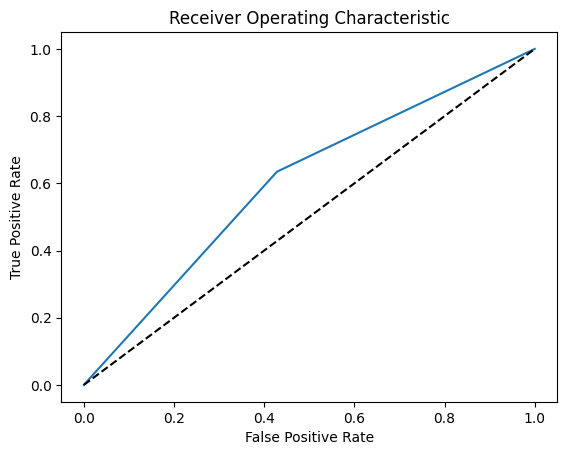

In [99]:
# Testing dan evaluasi model
model.eval()  # Set model ke mode evaluasi
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluasi
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

# Print evaluasi
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()


# **Perbandingan**

RNN:

RNN (Recurrent Neural Network) biasanya memiliki kinerja yang lebih rendah dibandingkan GRU dan LSTM. Hal ini karena arsitekturnya lebih sederhana dan sulit untuk menangkap informasi dari data yang lebih panjang atau jarak jauh dalam urutan data. Jadi, meskipun bisa digunakan, RNN kurang efektif dalam tugas-tugas yang membutuhkan pemahaman konteks yang lebih panjang.

GRU:

GRU (Gated Recurrent Unit) memiliki performa yang lebih baik daripada RNN. Ini karena GRU menggunakan mekanisme "gating" yang membantu model fokus pada informasi penting dan mengabaikan yang kurang relevan. Meski lebih baik dari RNN, GRU masih kalah dibandingkan LSTM dalam menangani data yang lebih panjang atau kompleks, karena LSTM dirancang khusus untuk itu.

LSTM:

LSTM (Long Short-Term Memory) adalah model yang paling efektif dari ketiganya. LSTM dapat menangkap informasi penting dari data yang lebih panjang atau kompleks, sehingga kinerjanya lebih baik dalam hal akurasi, presisi, recall, F1 score, dan AUC. LSTM sangat cocok untuk tugas-tugas yang memerlukan pemahaman konteks yang lebih dalam dan panjang, seperti analisis sentimen.